https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100587
project page: https://www.ncbi.nlm.nih.gov/bioproject/PRJNA392230
study: https://pmc.ncbi.nlm.nih.gov/articles/PMC6338737/
biosample_results: https://www.ncbi.nlm.nih.gov/biosample?Db=biosample&DbFrom=bioproject&Cmd=Link&LinkName=bioproject_biosample&LinkReadableName=BioSample&ordinalpos=1&IdsFromResult=234297

In [ ]:
import os
import re
import sys
import csv
import time
import random
import requests
import subprocess
from pathlib import Path
from typing import List, Union 
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.stats import f_oneway

import seaborn as sns
import matplotlib.pyplot as plt

from pysradb import SRAweb

from Bio import SeqIO

In [77]:
data_dir = Path.cwd().parent.parent.parent / 'HIV_Atlas_Creation' / 'data'

sequence_dir = data_dir / 'sequences'
assert sequence_dir.exists(), f"sequence_dir does not exist: {sequence_dir}"

annotation_dir = data_dir / 'annotation'
assert annotation_dir.exists(), f"annotation_dir does not exist: {annotation_dir}"

base_dir = Path.cwd().parent.parent

soft_dir = base_dir / 'soft'

prj_id = 'PRJNA392230'

outdir = base_dir / 'results' / prj_id
outdir.mkdir(parents=True, exist_ok=True)
prj_data_dir = outdir / 'data'
prj_data_dir.mkdir(parents=True, exist_ok=True)
prj_fastq_dir = prj_data_dir / 'fastq'
prj_fastq_dir.mkdir(parents=True, exist_ok=True)

prj_aln_dir = outdir / 'alignment'
prj_aln_dir.mkdir(parents=True, exist_ok=True)
prj_assembly_dir = outdir / 'assembly'
prj_assembly_dir.mkdir(parents=True, exist_ok=True)
prj_quant_dir = outdir / 'quantification'
prj_quant_dir.mkdir(parents=True, exist_ok=True)

hisat_idx_basename = base_dir / 'data' / 'PRJNA392230/reference'
reference_fasta_fname = base_dir / 'data' / 'PRJNA392230/reference.fasta'
reference_gtf_fname = base_dir / 'data' / 'PRJNA392230/reference.gtf'
t2g_fname = base_dir / 'data' / 'PRJNA392230/reference.t2g.tsv'
hiv_gtf_fname = base_dir / 'results/annotation_PRJNA392230/PRJNA392230.vira.gtf'
hiv_accid = "HIV"

biosample_results_fname = prj_data_dir / 'metadata/biosample_results.tsv'

sashimi_bin = "sashimi.py"
orfanage_bin = soft_dir / 'ORFanage/orfanage'

In [3]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, str(soft_dir / "genomic_scripts"))
%aimport definitions

In [ ]:
# load metadata
metadata_df = pd.read_csv(biosample_results_fname, sep='\t')

db = SRAweb()
batch_results = db.sra_metadata(metadata_df["sra"].tolist(), detailed=True)
metadata_df = metadata_df.merge(batch_results[["run_accession","sample_accession"]],left_on="sra",right_on="sample_accession",how="left")
metadata_df = metadata_df.drop(columns=["sample_accession"])
metadata_df.head()

,sample,biosample,sra,geo,run_accession
0,Mock_6h,SAMN07286048,SRS2320250,GSM2687511,SRR5763193
1,HIV_6h,SAMN07286047,SRS2320256,GSM2687517,SRR5763199
2,Mock_12h,SAMN07286046,SRS2320251,GSM2687512,SRR5763194
3,HIV_24h_r,SAMN07286045,SRS2320260,GSM2687521,SRR5763203
4,HIV_24h,SAMN07286044,SRS2320259,GSM2687520,SRR5763202


In [29]:
# extract column with experimental information
metadata_df["type_cat"] = metadata_df["sample"].str.split("_",n=1,expand=True)[0].str.strip()+"_tp"
metadata_df["timepoint_cat"] = metadata_df["sample"].str.split("_",n=1,expand=True)[1].str.strip()

metadata_df.to_csv(prj_data_dir / 'metadata/metadata.tsv',sep="\t",index=False)

pheno_df = metadata_df[["run_accession","type_cat","timepoint_cat"]]
pheno_df.columns = ["id","type_cat","timepoint_cat"]
pheno_df.to_csv(prj_data_dir / 'metadata/pheno.tsv',sep="\t",index=False)

metadata_df

,sample,biosample,sra,geo,run_accession,type_cat,timepoint_cat
0,Mock_6h,SAMN07286048,SRS2320250,GSM2687511,SRR5763193,Mock_tp,6h
1,HIV_6h,SAMN07286047,SRS2320256,GSM2687517,SRR5763199,HIV_tp,6h
2,Mock_12h,SAMN07286046,SRS2320251,GSM2687512,SRR5763194,Mock_tp,12h
3,HIV_24h_r,SAMN07286045,SRS2320260,GSM2687521,SRR5763203,HIV_tp,24h_r
4,HIV_24h,SAMN07286044,SRS2320259,GSM2687520,SRR5763202,HIV_tp,24h
5,HIV_30h,SAMN07286043,SRS2320261,GSM2687522,SRR5763204,HIV_tp,30h
6,HIV_12h,SAMN07286042,SRS2320257,GSM2687518,SRR5763200,HIV_tp,12h
7,Mock_30h,SAMN07286041,SRS2320255,GSM2687516,SRR5763198,Mock_tp,30h
8,HIV_18h,SAMN07286040,SRS2320258,GSM2687519,SRR5763201,HIV_tp,18h
9,Mock_24h_r,SAMN07286039,SRS2320254,GSM2687515,SRR5763197,Mock_tp,24h_r


In [4]:
pheno_fname = prj_data_dir / 'metadata/pheno.tsv'
metadata_df = pd.read_csv(prj_data_dir / 'metadata/metadata.tsv', sep='\t')
metadata_df

,sample,biosample,sra,geo,run_accession,type_cat,timepoint_cat
0,Mock_6h,SAMN07286048,SRS2320250,GSM2687511,SRR5763193,Mock_tp,6h
1,HIV_6h,SAMN07286047,SRS2320256,GSM2687517,SRR5763199,HIV_tp,6h
2,Mock_12h,SAMN07286046,SRS2320251,GSM2687512,SRR5763194,Mock_tp,12h
3,HIV_24h_r,SAMN07286045,SRS2320260,GSM2687521,SRR5763203,HIV_tp,24h_r
4,HIV_24h,SAMN07286044,SRS2320259,GSM2687520,SRR5763202,HIV_tp,24h
5,HIV_30h,SAMN07286043,SRS2320261,GSM2687522,SRR5763204,HIV_tp,30h
6,HIV_12h,SAMN07286042,SRS2320257,GSM2687518,SRR5763200,HIV_tp,12h
7,Mock_30h,SAMN07286041,SRS2320255,GSM2687516,SRR5763198,Mock_tp,30h
8,HIV_18h,SAMN07286040,SRS2320258,GSM2687519,SRR5763201,HIV_tp,18h
9,Mock_24h_r,SAMN07286039,SRS2320254,GSM2687515,SRR5763197,Mock_tp,24h_r


In [31]:
cmd_lst_fname = prj_fastq_dir / 'cmd_lst.txt'
with open(cmd_lst_fname, 'w') as outFP:
    for run_id in metadata_df["run_accession"].tolist():
        os.makedirs(prj_fastq_dir, exist_ok=True)
        cmd_dump = f"fasterq-dump {run_id} --temp {prj_fastq_dir} --outdir {prj_fastq_dir} --split-3"
        outFP.write(f"{cmd_dump}\n")

In [5]:
# we have the following features: sequencing_cat	treatment_cat	timepoint_cat
# need to setup groups of samples to compare
# instead of hierarchies - we'll just slice the dataframe and give it names and store in dict
cmp_groups = {
    ("Mock_tp","HIV_tp"):{
        "Mock_tp":metadata_df[(metadata_df["type_cat"] == "Mock_tp")]["run_accession"].tolist(),
        "HIV_tp":metadata_df[(metadata_df["type_cat"] == "HIV_tp")]["run_accession"].tolist()
    },
    ("6h","12h","18h","24h","24h_r","30h"): {
        "6h":metadata_df[(metadata_df["timepoint_cat"] == "6h")]["run_accession"].tolist(),
        "12h":metadata_df[(metadata_df["timepoint_cat"] == "12h")]["run_accession"].tolist(),
        "18h":metadata_df[(metadata_df["timepoint_cat"] == "18h")]["run_accession"].tolist(),
        "24h":metadata_df[(metadata_df["timepoint_cat"] == "24h")]["run_accession"].tolist(),
        "24h_r":metadata_df[(metadata_df["timepoint_cat"] == "24h_r")]["run_accession"].tolist(),
        "30h":metadata_df[(metadata_df["timepoint_cat"] == "30h")]["run_accession"].tolist()
    },
    ("Mock_tp_6h","Mock_tp_12h","Mock_tp_18h","Mock_tp_24h","Mock_tp_24h_r","Mock_tp_30h"): {
        "Mock_tp_6h":metadata_df[(metadata_df["type_cat"] == "Mock_tp")&(metadata_df["timepoint_cat"] == "6h")]["run_accession"].tolist(),
        "Mock_tp_12h":metadata_df[(metadata_df["type_cat"] == "Mock_tp")&(metadata_df["timepoint_cat"] == "12h")]["run_accession"].tolist(),
        "Mock_tp_18h":metadata_df[(metadata_df["type_cat"] == "Mock_tp")&(metadata_df["timepoint_cat"] == "18h")]["run_accession"].tolist(),
        "Mock_tp_24h":metadata_df[(metadata_df["type_cat"] == "Mock_tp")&(metadata_df["timepoint_cat"] == "24h")]["run_accession"].tolist(),
        "Mock_tp_24h_r":metadata_df[(metadata_df["type_cat"] == "Mock_tp")&(metadata_df["timepoint_cat"] == "24h_r")]["run_accession"].tolist(),
        "Mock_tp_30h":metadata_df[(metadata_df["type_cat"] == "Mock_tp")&(metadata_df["timepoint_cat"] == "30h")]["run_accession"].tolist()
    },
    ("HIV_tp_6h","HIV_tp_12h","HIV_tp_18h","HIV_tp_24h","HIV_tp_24h_r","HIV_tp_30h"): {
        "HIV_tp_6h":metadata_df[(metadata_df["type_cat"] == "HIV_tp")&(metadata_df["timepoint_cat"] == "6h")]["run_accession"].tolist(),
        "HIV_tp_12h":metadata_df[(metadata_df["type_cat"] == "HIV_tp")&(metadata_df["timepoint_cat"] == "12h")]["run_accession"].tolist(),
        "HIV_tp_18h":metadata_df[(metadata_df["type_cat"] == "HIV_tp")&(metadata_df["timepoint_cat"] == "18h")]["run_accession"].tolist(),
        "HIV_tp_24h":metadata_df[(metadata_df["type_cat"] == "HIV_tp")&(metadata_df["timepoint_cat"] == "24h")]["run_accession"].tolist(),
        "HIV_tp_24h_r":metadata_df[(metadata_df["type_cat"] == "HIV_tp")&(metadata_df["timepoint_cat"] == "24h_r")]["run_accession"].tolist(),
        "HIV_tp_30h":metadata_df[(metadata_df["type_cat"] == "HIV_tp")&(metadata_df["timepoint_cat"] == "30h")]["run_accession"].tolist()
    }
}

In [11]:
# align samples with hisat
cmd_lst_fname = prj_aln_dir / 'cmd_lst.txt'
with open(cmd_lst_fname, 'w') as outFP:
    for run_id in metadata_df["run_accession"].tolist():
        cmd = f"hisat2 -p 25 --score-min L,0,-2 --mp 2,2 -x {hisat_idx_basename} -U {prj_fastq_dir}/{run_id}.fastq -S {prj_aln_dir}/{run_id}.sam"
        outFP.write(f"{cmd}\n")

In [9]:
# sort reads by position
cmd_lst_fname = prj_aln_dir / 'cmd_lst.sort.txt'
with open(cmd_lst_fname, 'w') as outFP:
    for run_id in metadata_df["run_accession"].tolist():
        cmd = f"samtools sort -@ 25 -o {prj_aln_dir}/{run_id}.sorted.bam {prj_aln_dir}/{run_id}.sam && samtools index {prj_aln_dir}/{run_id}.sorted.bam"
        outFP.write(f"{cmd}\n")

In [11]:
# extract viral reads
cmd_lst_fname = prj_aln_dir / 'cmd_lst.extract.txt'
with open(cmd_lst_fname, 'w') as outFP:
    for run_id in metadata_df["run_accession"].tolist():
        cmd = f"samtools view -h {prj_aln_dir}/{run_id}.sorted.bam {hiv_accid} | samtools sort -o {prj_aln_dir}/{run_id}.{hiv_accid}.sorted.bam - && samtools index {prj_aln_dir}/{run_id}.{hiv_accid}.sorted.bam"
        outFP.write(f"{cmd}\n")

In [12]:
# assemble with stringtie
cmd_lst_fname = prj_assembly_dir / 'cmd_lst.txt'
with open(cmd_lst_fname, 'w') as outFP:
    for run_id in metadata_df["run_accession"].tolist():
        cmd = f"stringtie -p 12 -G {reference_gtf_fname} -o {prj_assembly_dir}/{run_id}.gtf {prj_aln_dir}/{run_id}.sorted.bam"
        outFP.write(f"{cmd}\n")

In [33]:
# prepare tiebrush aggreagations
tb_cmd_lst_fname = prj_aln_dir / 'tiebrush_cmd_lst.txt'
tiecov_cmd_lst_fname = prj_aln_dir / 'tiecov_cmd_lst.txt'
with open(tb_cmd_lst_fname, 'w') as tb_cmd_outFP, open(tiecov_cmd_lst_fname, 'w') as tiecov_cmd_outFP:
    for grp_name, grp_data in cmp_groups.items():
        all_name = ".".join(grp_name)
        # tb
        all_bam_fname = prj_aln_dir / f'{all_name}.{hiv_accid}.bam'
        all_bam_lst_fname = prj_aln_dir / f'{all_name}.lst'
        # tiecov
        all_junctions_fname = prj_aln_dir / f'{all_name}.{hiv_accid}.junctions.bed'
        all_cov_fname = prj_aln_dir / f'{all_name}.{hiv_accid}.coverage.bedgraph'
        with open(all_bam_lst_fname, 'w') as all_outFP:
            for exp_name, run_ids in grp_data.items():
                exp_bam_lst_fname = prj_aln_dir / f'{exp_name}.lst'
                exp_gtf_lst_fname = prj_assembly_dir / f'{exp_name}.lst'
                # tb
                exp_bam_fname = prj_aln_dir / f'{exp_name}.{hiv_accid}.bam'
                all_outFP.write(f"{exp_bam_fname}\n")
                # tiecov
                exp_junctions_fname = prj_aln_dir / f'{exp_name}.{hiv_accid}.junctions.bed'
                exp_cov_fname = prj_aln_dir / f'{exp_name}.{hiv_accid}.coverage.bedgraph'
                with open(exp_bam_lst_fname, 'w') as exp_outFP, open(exp_gtf_lst_fname, 'w') as exp_gtf_outFP:
                    for run_id in run_ids:
                        exp_outFP.write(f"{prj_aln_dir}/{run_id}.{hiv_accid}.sorted.bam\n")
                        exp_gtf_outFP.write(f"{prj_assembly_dir}/{run_id}.gtf\n")
                # tb
                tb_cmd = f"tiebrush -o {exp_bam_fname} {exp_bam_lst_fname}"
                tb_cmd_outFP.write(f"{tb_cmd}\n")
                # tiecov
                tiecov_cmd = f"tiecov -c {exp_cov_fname} -j {exp_junctions_fname} {exp_bam_fname}"
                tiecov_cmd_outFP.write(f"{tiecov_cmd}\n")
        # tb
        tb_cmd = f"tiebrush -o {all_bam_fname} {all_bam_lst_fname}"
        tb_cmd_outFP.write(f"{tb_cmd}\n")
        # tiecov
        tiecov_cmd = f"tiecov -c {all_cov_fname} -j {all_junctions_fname} {all_bam_fname}"
        tiecov_cmd_outFP.write(f"{tiecov_cmd}\n")


In [ ]:
# run gffcompare
for grp_name, grp_data in cmp_groups.items():
    all_name = ".".join(grp_name)
    all_gtf_lst_fname = prj_assembly_dir / f'{all_name}.lst'
    with open(all_gtf_lst_fname, 'w') as all_gtf_outFP:
        for exp_name, run_ids in grp_data.items():
            exp_gtf_lst_fname = prj_assembly_dir / f'{exp_name}.lst'
            
            gffcmp_exp_gtf_fname = prj_assembly_dir / f'{exp_name}.combined.gtf'
            gffcmp_exp_tracking_fname = prj_assembly_dir / f'{exp_name}.tracking'
            
            all_gtf_outFP.write(f"{gffcmp_exp_gtf_fname}\n")
            
            with open(exp_gtf_lst_fname, 'w') as exp_gtf_outFP:
                for run_id in run_ids:
                    exp_gtf_outFP.write(f"{prj_assembly_dir}/{run_id}.gtf\n")
                    
            definitions.run_gffcompare({"-D":None,"-r": reference_gtf_fname, "-p": f"{exp_name}", "-o": f"{prj_assembly_dir}/{exp_name}", "-i": exp_gtf_lst_fname})
            
            # subset
            # load the tids with the the seqid
            exp_gtf_df = definitions.get_attribute(gffcmp_exp_gtf_fname, ["transcript_id"],[0])
            exp_tids = exp_gtf_df[exp_gtf_df[0]==hiv_accid]["transcript_id"].tolist()
            # subset to the viral genome
            # subset gtf
            sub_gffcmp_exp_gtf_fname = prj_assembly_dir / f'{exp_name}.{hiv_accid}.gtf'
            sub_gffcmp_exp_tracking_fname = prj_assembly_dir / f'{exp_name}.{hiv_accid}.tracking'
            definitions.subset_gtf(gffcmp_exp_gtf_fname,sub_gffcmp_exp_gtf_fname,[],exp_tids)
            definitions.subset_tracking(gffcmp_exp_tracking_fname,sub_gffcmp_exp_tracking_fname,exp_tids)
            
    definitions.run_gffcompare({"-D":None,"-r": reference_gtf_fname, "-p": f"{all_name}", "-o": f"{prj_assembly_dir}/{all_name}", "-i": all_gtf_lst_fname})
    
    # subset
    gffcmp_all_gtf_fname = prj_assembly_dir / f'{all_name}.combined.gtf'
    gffcmp_all_tracking_fname = prj_assembly_dir / f'{all_name}.tracking'
    # load the tids with the the seqid
    all_gtf_df = definitions.get_attribute(gffcmp_all_gtf_fname, ["transcript_id"],[0])
    all_tids = all_gtf_df[all_gtf_df[0]==hiv_accid]["transcript_id"].tolist()
    # subset to the viral genome
    # subset gtf
    sub_gffcmp_all_gtf_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.gtf'
    sub_gffcmp_all_tracking_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.tracking'
    definitions.subset_gtf(gffcmp_all_gtf_fname,sub_gffcmp_all_gtf_fname,[],all_tids)
    definitions.subset_tracking(gffcmp_all_tracking_fname,sub_gffcmp_all_tracking_fname,all_tids)

In [ ]:
# run orfanage on novel transcripts
for grp_name, grp_data in cmp_groups.items():
    all_name = ".".join(grp_name)
    for exp_name, run_ids in grp_data.items():
        sub_gffcmp_exp_gtf_fname = prj_assembly_dir / f'{exp_name}.{hiv_accid}.gtf'
        orf_exp_gtf_fname = prj_assembly_dir / f'{exp_name}.{hiv_accid}.orfanage.gtf'
        cmd = f"{orfanage_bin} --mode FIRST --ilpi 100 --query {sub_gffcmp_exp_gtf_fname} --reference {reference_fasta_fname} --output {orf_exp_gtf_fname} {reference_gtf_fname}"
        print(cmd)
        subprocess.run(cmd, shell=True)

    sub_gffcmp_all_gtf_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.gtf'
    orf_all_gtf_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.orfanage.gtf'
    cmd = f"{orfanage_bin} --mode FIRST --ilpi 100 --query {sub_gffcmp_all_gtf_fname} --reference {reference_fasta_fname} --output {orf_all_gtf_fname} {reference_gtf_fname}"
    print(cmd)
    subprocess.run(cmd, shell=True)

In [12]:
# for each experiment - propagate expressions via tracking into the gtf
for grp_name, grp_data in cmp_groups.items():
    all_name = ".".join(grp_name)
    
    sub_gffcmp_all_tracking_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.tracking'
    hierarchy = {
        (all_name,sub_gffcmp_all_tracking_fname):{}
    }
    
    for exp_name, run_ids in grp_data.items():
        sub_gffcmp_exp_tracking_fname = prj_assembly_dir / f'{exp_name}.{hiv_accid}.tracking'
        hierarchy[(all_name,sub_gffcmp_all_tracking_fname)][(exp_name,sub_gffcmp_exp_tracking_fname)] = {}
        
    orf_all_gtf_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.orfanage.gtf'
    augmented_orf_all_gtf_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.orfanage.tracking.gtf'
    definitions.combine_tracking_gtf(orf_all_gtf_fname, hierarchy, augmented_orf_all_gtf_fname)

In [ ]:
# load and process stringtie results
strg_tdf = pd.DataFrame()
def load_and_process_stringtie(gtf_fname, all_name, experiments, num_significant_transcripts, out_basename):
    global strg_tdf
    # experiments is a dict of name to number of samples
    # load a table for each assembled transcript with the data
    columns = ["class_code", f"{all_name}_tpm_mean", f"{all_name}_num_samples"] + \
              [f"{exp_name}_tpm_mean" for exp_name in experiments] + \
              [f"{exp_name}_num_samples" for exp_name in experiments]
    exp_df = definitions.get_attribute(gtf_fname, columns)
    
    # Replace "-" with 0
    exp_df.replace("-", 0, inplace=True)
    
    # Convert to numeric
    num_cols = exp_df.columns.difference(['tid', 'class_code'])
    exp_df[num_cols] = exp_df[num_cols].astype(float)
    exp_df.sort_values(by=f"{all_name}_num_samples", ascending=False, inplace=True)

    # Compute percent samples
    exp_df[f"{all_name}_percent_samples"] = exp_df[f"{all_name}_num_samples"] / metadata_df.shape[0]
    for exp_name, run_ids in experiments.items():
        exp_df[f"{exp_name}_percent_samples"] = exp_df[f"{exp_name}_num_samples"] / len(run_ids)

    # Compute percentage sample difference for each experiment
    for exp_name in experiments.keys():
        # Sum percent_samples of all other experiments
        other_exps_percent_samples = sum(
            exp_df[f"{other_exp}_percent_samples"] 
            for other_exp in experiments.keys() if other_exp != exp_name
        )
        
        # Compute absolute difference
        exp_df[f"{exp_name}_perc_samples_diff"] = abs(
            exp_df[f"{exp_name}_percent_samples"] - other_exps_percent_samples
        )
        
        # Bin the percentage sample difference
        exp_df[f"{exp_name}_perc_samples_diff_bin"] = pd.cut(
            exp_df[f"{exp_name}_perc_samples_diff"], bins=10, labels=False
        )

    # isolate novel
    novel_exp_df = exp_df[~(exp_df["class_code"]=="=")].reset_index(drop=True)
    # total number of novel transcripts
    print(f"{novel_exp_df.shape[0]} novel transcripts detected in the dataset: {all_name}")

    # create subsets of most promising novel transcripts
    tids = novel_exp_df[novel_exp_df[f"{all_name}_percent_samples"]>0.1]["tid"].tolist()
    print(f"number of novel transcripts with >10% of samples in {all_name}: {len(tids)}")
    novel_gtf_fname = out_basename+".top_novel_num_samples.gtf"
    definitions.subset_gtf(gtf_fname,novel_gtf_fname,[],tids)
    
    # save exp_df
    exp_df.to_csv(out_basename+".exp_df.tsv",sep="\t",index=False)
    
    # use stringtie results to load up transcript quantifications 
    strg_tdf = pd.DataFrame()
    for exp_name, run_ids in experiments.items():
        for run_id in run_ids:
            if not (prj_assembly_dir / f"{run_id}.gtf").exists():
                continue
        
            tdf = definitions.get_chains(prj_assembly_dir / f"{run_id}.gtf","exon",True)
            tmp_df = definitions.get_attribute(prj_assembly_dir / f"{run_id}.gtf",["TPM","reference_id"])
            tdf = tdf.merge(tmp_df,on="tid")
            tdf["run_accession"] = run_id
            tdf["sample"] = exp_name
            strg_tdf = pd.concat([strg_tdf, tdf])

    strg_tdf = strg_tdf[(strg_tdf["seqid"]==hiv_accid)].reset_index(drop=True)
    strg_tdf["TPM"] = pd.to_numeric(strg_tdf["TPM"], errors='coerce')
    strg_tdf.to_csv(out_basename + ".transcript_tpm.tsv",sep="\t",index=False)
    
    # Pivot table for statistical analysis
    pivot_df = strg_tdf.pivot_table(index='reference_id', columns=['sample',"run_accession"], values='TPM')
    # Perform ANOVA to identify significant transcripts
    anova_results = []
    for tid, row in pivot_df.iterrows():
        groups = [row.filter(like=exp).dropna() for exp in experiments.keys()]
        
        # Ensure each group has more than one value (replicates)
        if all(len(group) > 1 for group in groups):
            stat, pval = f_oneway(*groups)  # Perform ANOVA
            anova_results.append((tid, pval))

    anova_df = pd.DataFrame(anova_results, columns=['reference_id', 'pval'])
    anova_df['significant'] = anova_df['pval'] < 0.05

    print(f"Number of significant transcripts: {anova_df['significant'].sum()}")
    anova_df.to_csv(out_basename + ".anova.tsv",sep="\t",index=False)
    
    significant_tids = anova_df[anova_df['significant']]['reference_id'].tolist()
    top_transcripts = significant_tids[:num_significant_transcripts]

    # setup the figure of split violin plots for significant tids
    fig, axes = plt.subplots(1, num_significant_transcripts, figsize=(4*num_significant_transcripts, 6), sharey=False)
    for i, tid in enumerate(top_transcripts):
        transcript_data = strg_tdf[strg_tdf['reference_id'] == tid]
        ax = axes[i] if num_significant_transcripts > 1 else axes
        sns.violinplot(
            data=transcript_data,
            x='reference_id',
            y='TPM',
            hue='sample',
            split=True,
            inner='quart',
            fill=False,
            ax=ax
        )
        
        ax.set_title(f"{tid}")
        ax.set_xlabel("") 
        if i > 0:
            ax.set_ylabel("")
        if i < num_significant_transcripts - 1:
            ax.get_legend().remove()
    plt.tight_layout()
    plt.savefig(out_basename + ".violin_plot.png")
    
    # write a list of tiecov coverage and junction files and names of monkeys for the cov/sj/tn params of sashimi
    cov_lst_fname = out_basename + '.cov_lst.txt'
    with open(cov_lst_fname, 'w') as outFP:
        for exp_name, run_ids in experiments.items():
            outFP.write(f"{prj_aln_dir}/{exp_name}.{hiv_accid}.coverage.bedgraph\n")
    sj_lst_fname = out_basename + '.sj_lst.txt'
    with open(sj_lst_fname, 'w') as outFP:
        for exp_name, run_ids in experiments.items():
            outFP.write(f"{prj_aln_dir}/{exp_name}.{hiv_accid}.junctions.bed\n")
    tn_lst_fname = out_basename + '.tn_lst.txt'
    with open(tn_lst_fname, 'w') as outFP:
        for exp_name, run_ids in experiments.items():
            outFP.write(f"{exp_name}\n")
            
    # build sashimi plots for the significant transcripts
    # we want to compare tiebrush between T034 and Ay69 for a given transcript only

    viral_tids = [x for x in strg_tdf['reference_id'].tolist() if x != "-"]
    viral_gtf_fname = out_basename + '.viral.gtf'
    definitions.subset_gtf(reference_gtf_fname,viral_gtf_fname,[],viral_tids)
    # build for entire transcriptome
    sashimi_svg_fname = out_basename + '.svg'
    sashimi_cmd = [sashimi_bin,
                    "--title",tid,
                    "--gtf",str(viral_gtf_fname),
                    "-o",str(sashimi_svg_fname),
                    "--normalize",
                    "--subtract","0",
                    "--intron_scale","1",
                    "--exon_scale","1",
                    "--tn",str(tn_lst_fname),
                    "--cov",str(cov_lst_fname),
                    "--sj",str(sj_lst_fname)]
    subprocess.call(sashimi_cmd)

    # SASHIMI WITHOUT NORMALIZATION
    sashimi_svg_fname = out_basename + '.non_normalized.svg'

    sashimi_cmd = [sashimi_bin,
                    "--title",tid,
                    "--gtf",str(viral_gtf_fname),
                    "-o",str(sashimi_svg_fname),
                    "--intron_scale","1",
                    "--exon_scale","1",
                    "--tn",str(tn_lst_fname),
                    "--cov",str(cov_lst_fname),
                    "--sj",str(sj_lst_fname),
                    "--subtract","0"]
    subprocess.call(sashimi_cmd)

    # now build transcript-specific plots
    for tid in set(strg_tdf['reference_id'].tolist()):
        if tid == "-": # skip non-reference transcripts
            continue
        try:
            tx_gtf_fname = out_basename + f'.{tid}.gtf'
            tx_svg_fname = out_basename + f'.{tid}.svg'

            # extract the transcript from the gtf
            definitions.subset_gtf(reference_gtf_fname,tx_gtf_fname,False,[tid])

            # build sashimi plot
            sashimi_cmd = [sashimi_bin,
                            "--title",tid,
                            "--gtf",str(tx_gtf_fname),
                            "-o",str(tx_svg_fname),
                            "--normalize",
                            "--subtract","0",
                            "--intron_scale","1",
                            "--exon_scale","1",
                            "--tn",str(tn_lst_fname),
                            "--cov",str(cov_lst_fname),
                            "--sj",str(sj_lst_fname)]
            subprocess.call(sashimi_cmd)

            # SASHIMI WITHOUT NORMALIZATION
            tx_svg_fname = out_basename + f'{tid}.non_normalized.svg'

            sashimi_cmd = [sashimi_bin,
                            "--title",tid,
                            "--gtf",str(tx_gtf_fname),
                            "-o",str(tx_svg_fname),
                            "--intron_scale","1",
                            "--exon_scale","1",
                            "--tn",str(tn_lst_fname),
                            "--cov",str(cov_lst_fname),
                            "--sj",str(sj_lst_fname),
                            "--subtract","0"]
            subprocess.call(sashimi_cmd)
        except Exception as e:
            print(f"Error processing {tid}: {e}")
            continue

    
for grp_name, grp_data in cmp_groups.items():
    all_name = ".".join(grp_name)
    print(f"Processing group: {all_name}")
    
    out_all_name_dir = prj_quant_dir / all_name
    out_all_name_dir.mkdir(parents=True, exist_ok=True)
    
    gtf_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.orfanage.tracking.gtf'
    out_basename = str(out_all_name_dir / f'{all_name}.{hiv_accid}.orfanage.tracking')
    experiments = {exp_name: run_ids for exp_name, run_ids in grp_data.items()}
    load_and_process_stringtie(gtf_fname, all_name, experiments, 5, out_basename)

In [ ]:
grp_name = ("HIV_tp_6h","HIV_tp_12h","HIV_tp_18h","HIV_tp_24h","HIV_tp_24h_r","HIV_tp_30h")

# plot change in transcript abundance over timepoints
all_name = ".".join(grp_name)
out_all_name_dir = prj_quant_dir / all_name
gtf_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.orfanage.tracking.gtf'
out_basename = str(out_all_name_dir / f'{all_name}.{hiv_accid}.orfanage.tracking')
exp_df = pd.read_csv(out_basename+".exp_df.tsv",sep="\t")

timepoints = {}
for exp_name, run_ids in cmp_groups[grp_name].items():
    for tid in exp_df["tid"].tolist():
        if tid not in timepoints:
            timepoints[tid] = []
        timepoints[tid].append((exp_name.split("_",2)[2],exp_df[exp_df["tid"]==tid][f"{exp_name}_tpm_mean"].tolist()))

# Convert to DataFrame
records = []
for transcript, timepoints in timepoints.items():
    for timepoint, expression in timepoints:
        records.append({'Transcript': transcript, 'Timepoint': timepoint, 'Expression': expression[0]})
df = pd.DataFrame(records)

# Sort DataFrame for proper plotting
df['Timepoint'] = pd.Categorical(df['Timepoint'], categories=["6h", "12h", "18h", "24h", "24h_r", "30h"], ordered=True)
df = df.sort_values(['Transcript', 'Timepoint'])

tmp = definitions.get_attribute(gtf_fname, ["class_code","cmp_ref"])
df = df.merge(tmp,left_on="Transcript", right_on="tid",how="left")
df = df[df["class_code"]=="="].reset_index(drop=True)

df.drop(columns=["tid","Transcript","class_code"],inplace=True)

df.rename(columns={"cmp_ref":"Transcript"}, inplace=True)

df.head()

,Timepoint,Expression,Transcript
0,6h,0.042467,Vpr.4
1,12h,0.040806,Vpr.4
2,18h,30.026129,Vpr.4
3,24h,62.111900,Vpr.4
4,24h_r,26.295824,Vpr.4


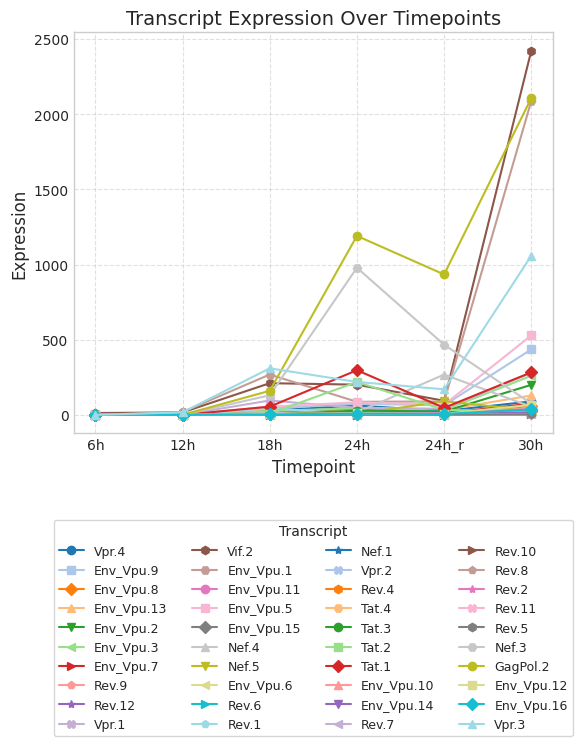

In [72]:
palette = sns.color_palette("tab20", len(df['Transcript'].unique()))
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'h', 'H'] * (len(df['Transcript'].unique()) // 12 + 1)

# Plot with unique colors and markers for each transcript
plt.figure(figsize=(6, 8))
for idx, transcript in enumerate(df['Transcript'].unique()):
    subset = df[df['Transcript'] == transcript]
    plt.plot(
        subset['Timepoint'], subset['Expression'], 
        marker=markers[idx % len(markers)], 
        color=palette[idx % len(palette)], 
        label=transcript
    )

plt.xlabel("Timepoint")
plt.ylabel("Expression")
plt.title("Transcript Expression Over Timepoints")
plt.legend(title="Transcript", loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [73]:
def load_junctions(junc_fname,gtf_fname):
    # now we should plot distribution of known to novel acceptor and donor sites

    # first we load junctions and label them as known vs novel
    junc_df = pd.read_csv(junc_fname, sep="\t", names=["seqid","start","end","name","count","strand"], skiprows=1)
    junc_df = junc_df[junc_df["strand"]=="+"].reset_index(drop=True)

    # split into donor and acceptor dataframes
    donor_df = junc_df[["start","count"]].groupby(["start"]).sum().reset_index()
    donor_df.rename(columns={"start":"pos"}, inplace=True)
    acceptor_df = junc_df[["end","count"]].groupby(["end"]).sum().reset_index()
    acceptor_df.rename(columns={"end":"pos"}, inplace=True)

    # load introns from the gtf
    edf = definitions.get_chains(gtf_fname,"exon",True)
    donors = set()
    acceptors = set()
    for i,row in edf.iterrows():
        chain = row["chain"]
        if len(chain)==1:
            continue
        for j in range(1,len(chain)):
            donors.add(chain[j-1][1])
            acceptors.add(chain[j][0]-1)

    donor_df["known"] = np.where(donor_df["pos"].isin(donors),"Known","Novel")
    acceptor_df["known"] = np.where(acceptor_df["pos"].isin(acceptors),"Known","Novel")

    donor_df['type'] = 'Donor'
    acceptor_df['type'] = 'Acceptor'

    # Combine both DataFrames
    combined_df = pd.concat([donor_df, acceptor_df])
    return combined_df

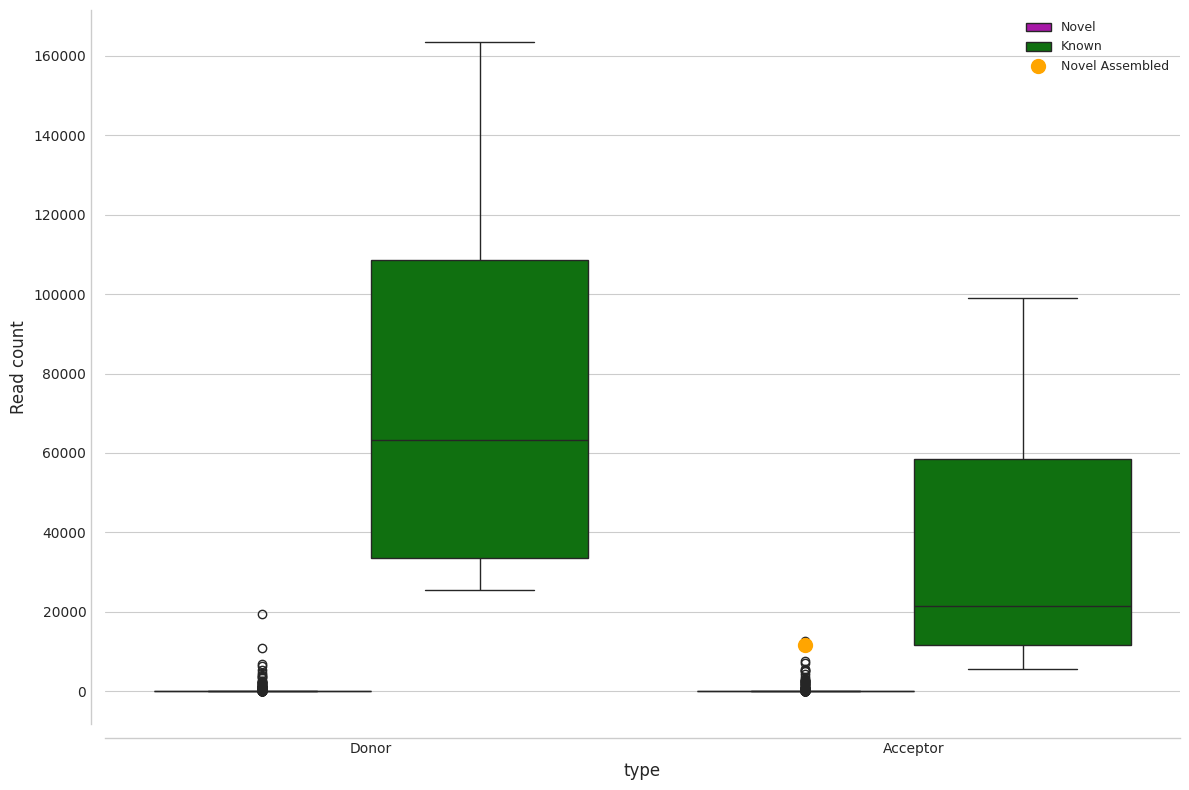

In [122]:
junc_fname = prj_aln_dir / f'{all_name}.{hiv_accid}.junctions.bed'
combined_df = load_junctions(junc_fname,hiv_gtf_fname)

# plot donors and acceptors but this time only including assembled positions and coloring novel on the same box in a different color
assembled_gtf_fname = prj_assembly_dir / f'{all_name}.{hiv_accid}.orfanage.tracking.gtf'
assembled_df = load_junctions(junc_fname,assembled_gtf_fname)
assembled_df.rename(columns={"known":"assembled"}, inplace=True)
assembled_df["assembled"] = np.where(assembled_df["assembled"]=="Known","Yes","No")
assembled_df = assembled_df[assembled_df["assembled"]=="Yes"].reset_index(drop=True)

combined_assembled_df = combined_df.merge(assembled_df[["pos","type","assembled"]],on=["pos","type"],how="left")

plt.figure(figsize=(12, 8))
# Create the boxplot
sns.boxplot(
    x="type",
    y="count",
    hue="known",
    palette=["m", "g"],
    data=combined_assembled_df
)

# Add orange dots for novel points with x-position jitter
novel_points = combined_assembled_df[(combined_assembled_df["known"]=="Novel")&(combined_assembled_df["assembled"] == "Yes")]

# Get the categorical positions
categories = combined_assembled_df["type"].unique()
x_positions = np.array([list(categories).index(t) for t in novel_points["type"]])

# Apply jitter of -0.2
x_pos = x_positions - 0.2

# Plot with jittered positions
plt.scatter(
    x=x_pos,
    y=novel_points["count"],
    color="orange",
    s=100,
    label="Novel Assembled",
    zorder=10
)

# Adjust the appearance
sns.despine(offset=10)
plt.ylabel("Read count")
plt.legend(loc="upper right")
plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
# let's now plot change in donor/acceptor usage over the timepoints
timepoints = {"donors":{},"acceptors":{}}
for exp_name, run_ids in cmp_groups[grp_name].items():
    junc_fname = prj_aln_dir / f'{exp_name}.{hiv_accid}.junctions.bed'
    junc_df = load_junctions(junc_fname,hiv_gtf_fname)
    for i,row in junc_df[junc_df["known"]=="Known"].iterrows():
        if row["type"]=="Donor" and row["pos"] not in timepoints["donors"]:
            timepoints["donors"][row["pos"]] = []
        if row["type"]=="Acceptor" and row["pos"] not in timepoints["acceptors"]:
            timepoints["acceptors"][row["pos"]] = []
            
        if row["type"]=="Donor":
            timepoints["donors"][row["pos"]].append((exp_name.split("_",2)[2],row["count"]))
        else:
            timepoints["acceptors"][row["pos"]].append((exp_name.split("_",2)[2],row["count"]))
        
timepoints

{'donors': {743: [('6h', 45),
   ('12h', 261),
   ('18h', 16635),
   ('24h', 45331),
   ('24h_r', 29383),
   ('30h', 71699)],
  4962: [('6h', 24),
   ('12h', 78),
   ('18h', 4002),
   ('24h', 9736),
   ('24h_r', 6739),
   ('30h', 15549)],
  5463: [('6h', 20),
   ('12h', 55),
   ('18h', 2624),
   ('24h', 6622),
   ('24h_r', 4931),
   ('30h', 11366)],
  6044: [('6h', 41),
   ('12h', 176),
   ('18h', 9969),
   ('24h', 23853),
   ('24h_r', 19307),
   ('30h', 37127)]},
 'acceptors': {4912: [('6h', 18),
   ('12h', 87),
   ('18h', 5796),
   ('24h', 14373),
   ('24h_r', 8914),
   ('30h', 23475)],
  5389: [('6h', 14),
   ('12h', 66),
   ('18h', 3484),
   ('24h', 7767),
   ('24h_r', 5223),
   ('30h', 12139)],
  5776: [('6h', 3),
   ('12h', 34),
   ('18h', 1465),
   ('24h', 3906),
   ('24h_r', 2580),
   ('30h', 6176)],
  5935: [('6h', 18),
   ('12h', 21),
   ('18h', 337),
   ('24h', 1564),
   ('24h_r', 719),
   ('30h', 2904)],
  5953: [('6h', 6),
   ('12h', 28),
   ('18h', 1046),
   ('24h', 3163)

In [91]:
# Convert dictionary to DataFrame
rows = []
for category, ids in timepoints.items():
    for id, values in ids.items():
        for timepoint, count in values:
            rows.append({"Category": category, "Position": id, "Timepoint": timepoint, "Count": count})

df = pd.DataFrame(rows)
df

,Category,Position,Timepoint,Count
0,donors,743,6h,45
1,donors,743,12h,261
2,donors,743,18h,16635
3,donors,743,24h,45331
4,donors,743,24h_r,29383
...,...,...,...,...
67,acceptors,8221,12h,98
68,acceptors,8221,18h,7529
69,acceptors,8221,24h,19822
70,acceptors,8221,24h_r,16751


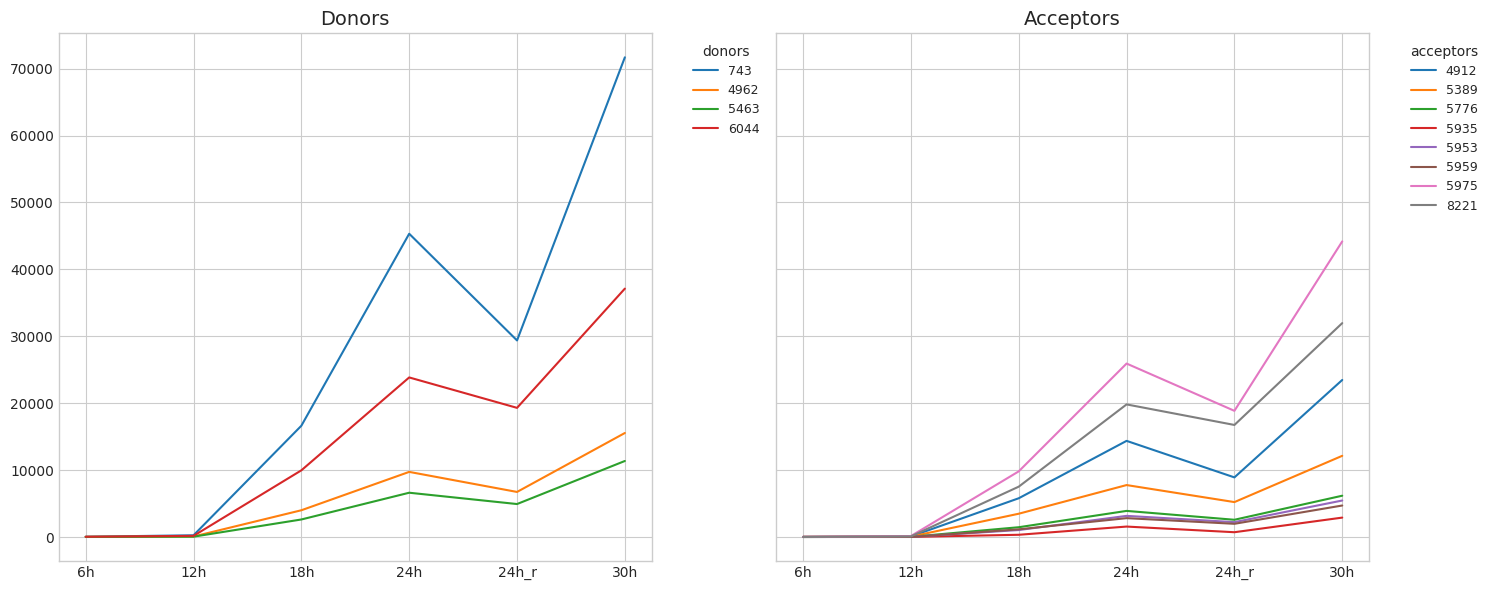

In [94]:
# Convert Timepoint to categorical for sorting
time_order = ['6h', '12h', '18h', '24h', '24h_r', '30h']
df['Timepoint'] = pd.Categorical(df['Timepoint'], categories=time_order, ordered=True)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for i, category in enumerate(['donors', 'acceptors']):
    ax = axes[i]
    subset = df[df['Category'] == category]
    for donor_id, group in subset.groupby('Position'):
        ax.plot(group['Timepoint'], group['Count'], label=f"{donor_id}")
    ax.set_title(category.capitalize())
    ax.legend(title=category, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()